In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importation des données d'entrainement 

In [ ]:
df = pd.read_csv("training.csv")
features = ["sigma", "theta", "kappa", "strike", "T"]
param_range = {param: [min(df[param]), max(df[param])] for param in df.columns}
X = df[features].values
y = df["expected_payoff"].values

In [3]:
#correlation entre les differentes features et le payoff
print(df.corr()["expected_payoff"])

sigma              0.086191
theta             -0.020348
kappa              0.014838
strike            -0.952136
T                  0.184409
expected_payoff    1.000000
error              0.795475
Ntraj                   NaN
Name: expected_payoff, dtype: float64


In [4]:
X.shape, y.shape

((320000, 5), (320000,))

# Importation des données de test

In [ ]:
df = pd.read_csv("testing.csv")
X_test = df[features].values    
y_test = df["expected_payoff"].values

In [6]:
X_test.shape, y_test.shape

((1024, 5), (1024,))

# Création du Modèle

In [7]:
class Net(torch.nn.Module):
    def __init__(self, hidden_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(5, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, 1)
        self.out = torch.nn.Softplus()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.out(x)
        return x.squeeze()

# Entraînement sur GPU du modèle

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # entrainement sur GPU
print(device)

# conversion des données en tenseurs
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset = TensorDataset(X, y)
dataset_test = TensorDataset(X_test, y_test)

dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=4096, shuffle=False)

# initialisation du modèle, de l'optimiseur et de la fonction de coût
model = Net(256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss(reduction='mean')
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

cuda:0


In [9]:
list_loss = []
list_loss_test = []

nb_epochs = 200

for epoch in range(nb_epochs):
    model.train()
    loss_epoch = 0
    for i, (X_batch, y_batch) in enumerate(dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.cpu().detach().numpy()
    list_loss.append(loss_epoch / len(dataloader))
    scheduler.step()
    
    model.eval()
    loss_epoch_test = 0
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(dataloader_test):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss_epoch_test += loss.cpu().detach().numpy()
    list_loss_test.append(loss_epoch_test / len(dataloader_test))

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: loss = {list_loss[-1]}, loss_test = {list_loss_test[-1]}")

Epoch 0: loss = 0.023413872346282005, loss_test = 0.0011066150618717074
Epoch 20: loss = 3.950108748540515e-06, loss_test = 1.3210636097937822e-05
Epoch 40: loss = 2.3157967916631605e-06, loss_test = 1.4597491826862097e-05
Epoch 60: loss = 2.5474189442320494e-06, loss_test = 1.1083549907198176e-05
Epoch 80: loss = 2.848059693860705e-06, loss_test = 9.194087397190742e-06
Epoch 100: loss = 1.3770719533567899e-06, loss_test = 8.071559932432137e-06
Epoch 120: loss = 1.7101125422414043e-06, loss_test = 8.160866855178028e-06
Epoch 140: loss = 1.6625625676169875e-06, loss_test = 8.264405551017262e-06
Epoch 160: loss = 1.4578503169104806e-06, loss_test = 8.136134965752717e-06
Epoch 180: loss = 1.3887423619962647e-06, loss_test = 8.681582585268188e-06


# Affichage des résultats d'entrainement

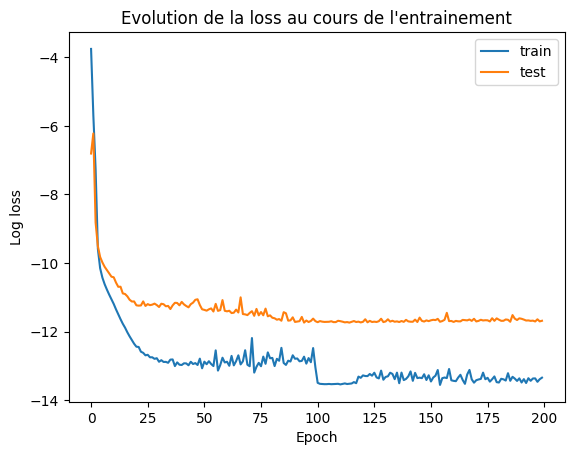

In [10]:
plt.figure()
plt.plot(np.log(list_loss), label="train")
plt.plot(np.log(list_loss_test), label="test")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.title("Evolution de la loss au cours de l'entrainement")
plt.legend()
plt.show()

# Analyse de la régularité du modèle

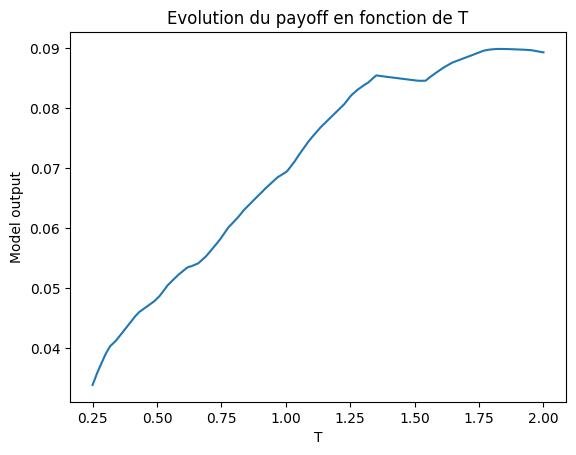

In [11]:
# analyse de la croissance en T du modèle
model.eval()
nb_points = 100000
T_range = np.linspace(0.25, 2, nb_points)
sigma, theta, kappa, strike = 0.15, -0.3, 0.1, 1.0
X = torch.tensor([[sigma, theta, kappa, strike, T] for T in T_range], dtype=torch.float32).to(device)
y = model(X).cpu().detach().numpy()

plt.plot(T_range, y)
plt.xlabel("T")
plt.ylabel("Model output")
plt.title("Evolution du payoff en fonction de T")
plt.show()

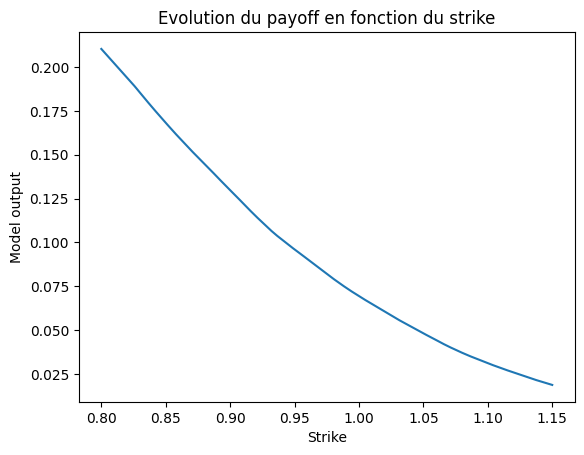

In [12]:
#analyse de la décroissance en strike du modèle
nb_points = 100000
strike_range = np.linspace(0.8, 1.15, nb_points)
sigma, theta, kappa, T = 0.15, -0.3, 0.1, 1.0

X = torch.tensor([[sigma, theta, kappa, strike, T] for strike in strike_range], dtype=torch.float32).to(device)
y = model(X).cpu().detach().numpy()

plt.plot(strike_range, y)
plt.xlabel("Strike")
plt.ylabel("Model output")
plt.title("Evolution du payoff en fonction du strike")
plt.show()

In [14]:
#echantillonage aléatoire 
nb_points = 1000000
points = np.random.rand(nb_points, 5)
points[:, 0] = 0.1 + 0.095 * points[:, 0]
points[:, 1] = -0.3 + 0.095 * points[:, 1]
points[:, 2] = 0.1 + 0.095 * points[:, 2]
points[:, 3] = 0.8 + 0.35 * points[:, 3]
points[:, 4] = 0.25 + 1.75 * points[:, 4]

X = torch.tensor(points, dtype=torch.float32).to(device)
X.requires_grad = True
y = model(X)

# calcul des gradients
gradients_1 = torch.autograd.grad(
    outputs=y,
    inputs=X,
    grad_outputs=torch.ones_like(y),
    create_graph=True
)[0]

# dérivée par rapport a T et K
grad_T = gradients_1[:, 4]
grad_K = gradients_1[:, 3]

# calcul de la dérivée seconde par rapport a K
gradients_2 = torch.autograd.grad(
    outputs=grad_K,
    inputs=X,
    grad_outputs=torch.ones_like(grad_K),
    create_graph=True
)[0]

# dérivée seconde par rapport a K
grad_K2 = gradients_2[:, 3]

print('pourcentage de points ou la dérivée par rapport a T est négative :', len(grad_T[grad_T > 0]) / nb_points)
print('nombre de points ou la dérivée par rapport a K est positive :', len(grad_K[grad_K > 0]))
print('nombre de points ou la dérivée seconde par rapport a K est négative :', len(grad_K2[grad_K2 < 0]))

OutOfMemoryError: CUDA out of memory. Tried to allocate 978.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 13.49 GiB is allocated by PyTorch, and 134.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)